### EVI Trends with Conflict Data

In [35]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import sys
import os
from os.path import join, expanduser
from shapely.geometry import Point
import folium as flm
import rasterio as rio
from rasterio.plot import show
sys.path.append('C:/Users/ishaa/OneDrive/Desktop/DataLab/Syria/syria-economic-monitor/GEE_Zonal/src/gee_zonal')  # Replace with the actual path to the GEE_Zonal repository
import gee_helpers
from gee_helpers import gpd_to_gee

import folium
from folium import plugins
import requests

In [2]:
import ee
ee.Initialize()

In [3]:
base_path = "C:\\Users\\ishaa\\OneDrive\\Desktop\\DataLab\\Syria\\syria-economic-monitor"

In [4]:
iso3 = "SYR"
country = "Syria"
release_type = "gbOpen"

adm = "ADM0"
geo_url = f"https://www.geoboundaries.org/api/current/{release_type}/{iso3}/{adm}/"
res = requests.get(geo_url).json()
print("Reading " + res["gjDownloadURL"])
adm0_syr = gpd.read_file(res["gjDownloadURL"])

adm = "ADM1"
geo_url = f"https://www.geoboundaries.org/api/current/{release_type}/{iso3}/{adm}/"
res = requests.get(geo_url).json()
print("Reading " + res["gjDownloadURL"])
adm1_syr = gpd.read_file(res["gjDownloadURL"])

adm = "ADM2"
geo_url = f"https://www.geoboundaries.org/api/current/{release_type}/{iso3}/{adm}/"
res = requests.get(geo_url).json()
print("Reading " + res["gjDownloadURL"])
adm2_syr = gpd.read_file(res["gjDownloadURL"])


Reading https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/SYR/ADM0/geoBoundaries-SYR-ADM0.geojson
Reading https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/SYR/ADM1/geoBoundaries-SYR-ADM1.geojson
Reading https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/SYR/ADM2/geoBoundaries-SYR-ADM2.geojson


In [15]:
aoi = gpd_to_gee(adm0_syr)
coords = aoi.geometry().centroid().coordinates().getInfo()
#print(coords)
centx ,centy = coords[0] , coords[1]

In [6]:
monthly_evi_2015_2024 = pd.read_csv(os.path.join(base_path,'data','Monthly_EVI_Syria_2010_2024_2.csv'))
#monthly_evi_2015_2024=pd.concat([monthly_evi_2015_2024,monthly_evi_2024],axis=0)
monthly_evi_2015_2024 = monthly_evi_2015_2024.drop(['system:index'],axis=1)
monthly_evi_2015_2024.head()

,mean_evi,month,year,.geo
0,1848.235463,1,2010,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,2516.908848,2,2010,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,3199.153014,3,2010,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,2315.691393,4,2010,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,1404.037908,5,2010,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [7]:
#loading boundaries 
import json
adm0_path = os.path.join(base_path,'data','boundaries','syr_admin0.shp')
syr_adm0 = gpd.read_file(adm0_path)
syr_adm0.to_file("syria_boundary.geojson", driver="GeoJSON")
with open("syria_boundary.geojson") as f:
    syr_geojson = json.load(f)
syria_geometry = ee.Geometry(syr_geojson['features'][0]['geometry'])


adm1_path = os.path.join(base_path,'data','boundaries','syr_admin1.shp')
syr_adm1 = gpd.read_file(adm1_path)
syr_adm1.to_file("syria_boundary1.geojson", driver="GeoJSON")
with open("syria_boundary1.geojson") as f:
    syr_geojson_adm1 = json.load(f)
syr_adm1_geometry = ee.Geometry(syr_geojson_adm1['features'][0]['geometry'])

In [8]:
# Load the ACLED data (make sure to have latitude and longitude columns)
# Load the ACLED conflict data
acled_data_path = os.path.join(base_path, 'data', '2011-01-01-2024-11-01-Middle_East-Syria.csv')
acled_data = pd.read_csv(acled_data_path, parse_dates=['event_date'])
acled_gdf = gpd.GeoDataFrame(acled_data, geometry=gpd.points_from_xy(acled_data.longitude, acled_data.latitude))

# Filter for events in 2023 and within the Sudan region
acled_data_2023 = acled_data[(acled_data['event_date'].dt.year == 2023) & 
                             (acled_data['country'] == 'Syria')]

acled_data_2024 = acled_data[(acled_data['event_date'].dt.year == 2024) & 
                             (acled_data['country'] == 'Syria')]

acled_2023_gdf = gpd.GeoDataFrame(
    acled_data_2023, 
    geometry=gpd.points_from_xy(acled_data_2023.longitude, acled_data_2023.latitude),
    crs="EPSG:4326"  # Set the appropriate CRS, e.g., WGS84
)

# Ensure both GeoDataFrames are in the same CRS
acled_2023_gdf = acled_2023_gdf.to_crs(syr_adm1.crs)

acled_2024_gdf = gpd.GeoDataFrame(
    acled_data_2024, 
    geometry=gpd.points_from_xy(acled_data_2024.longitude, acled_data_2024.latitude),
    crs="EPSG:4326"  # Set the appropriate CRS, e.g., WGS84
)

# Ensure both GeoDataFrames are in the same CRS
acled_2024_gdf = acled_2024_gdf.to_crs(syr_adm1.crs)

C:\Users\ishaa\AppData\Local\Temp\ipykernel_16500\3422586619.py:4: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  acled_data = pd.read_csv(acled_data_path, parse_dates=['event_date'])
C:\Users\ishaa\AppData\Local\Temp\ipykernel_16500\3422586619.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  acled_data = pd.read_csv(acled_data_path, parse_dates=['event_date'])


In [9]:
# Step 1: Rename 'admin1' to 'State_En' for consistency
acled_data = acled_data.rename(columns={'admin1': 'State_En'})

# Step 2: Aggregate fatalities and count events for each region in ACLED data
acled_aggregated = acled_data.groupby('State_En').agg(
    Total_Fatalities=('fatalities', 'sum'),
    Event_Count=('event_id_cnty', 'count')
).reset_index()

In [10]:
acled_aggregated.head(5)

,State_En,Total_Fatalities,Event_Count
0,Al Hasakeh,6596,9772
1,Aleppo,16739,24499
2,Ar Raqqa,13579,8790
3,As Sweida,1270,1992
4,Damascus,3260,1850


In [11]:
top_n = 5  # Change this to the number of top rows you want
top_conflict_admin1 = acled_aggregated.nlargest(top_n, 'Total_Fatalities')
top_conflict_admin1

,State_En,Total_Fatalities,Event_Count
6,Deir ez Zor,25478,15339
1,Aleppo,16739,24499
9,Idleb,16187,26864
12,Rural Damascus,15672,8533
2,Ar Raqqa,13579,8790


In [12]:
low_n = 5  # Change this to the number of top rows you want
low_conflict_admin1 = acled_aggregated.nsmallest(top_n, 'Total_Fatalities')
low_conflict_admin1

,State_En,Total_Fatalities,Event_Count
13,Tartous,64,57
11,Quneitra,823,1614
3,As Sweida,1270,1992
10,Lattakia,2235,2565
4,Damascus,3260,1850


In [16]:
start_period = ee.Date("2010-01-01")
end_period = ee.Date("2024-12-31")

terra = (
    ee.ImageCollection("MODIS/061/MOD13Q1")
    .select(["EVI", "SummaryQA", "DetailedQA"])
    .filterDate(start_period, end_period)
)
aqua = (
    ee.ImageCollection("MODIS/061/MYD13Q1")
    .select(["EVI", "SummaryQA", "DetailedQA"])
    .filterDate(start_period, end_period)
)

modis = terra.select("EVI").merge(aqua.select("EVI"))
modis = modis.sort("system:time_start")


def bitwiseExtract(value, fromBit, toBit=None):
    if toBit == None:
        toBit = fromBit
    maskSize = ee.Number(1).add(toBit).subtract(fromBit)
    mask = ee.Number(1).leftShift(maskSize).subtract(1)
    return value.rightShift(fromBit).bitwiseAnd(mask)


# Applying the SummaryQA  and DetailedQA
def modisQA_mask(image):
    sqa = image.select("SummaryQA")
    dqa = image.select("DetailedQA")
    viQualityFlagsS = bitwiseExtract(sqa, 0, 1)
    viQualityFlagsD = bitwiseExtract(dqa, 0, 1)
    # viUsefulnessFlagsD = bitwiseExtract(dqa, 2, 5)
    viSnowIceFlagsD = bitwiseExtract(dqa, 14)
    viShadowFlagsD = bitwiseExtract(dqa, 15)
    # Good data, use with confidence
    mask = (
        viQualityFlagsS.eq(0)
        .And(viQualityFlagsD.eq(0))
        .And(viQualityFlagsS.eq(1))
        .And(viQualityFlagsD.eq(1))
        .And(viSnowIceFlagsD)
        .eq(0)
    )
    # .And(viShadowFlagsD).eq(0); # No shadow
    return image.updateMask(mask)


mod13q1_QC = terra.map(modisQA_mask)
myd13q1_QC = aqua.map(modisQA_mask)

mxd13q1_cleaned = mod13q1_QC.select("EVI").merge(myd13q1_QC.select("EVI"))
mxd13q1_cleaned_sorted = mxd13q1_cleaned.sort("system:time_start")

bool_dict = {
    "0": "ocean",
    "1": "non_crop",
    "2": "crop_irrigated",
    "3": "crop_rainfed",
}
lgrip30 = ee.ImageCollection(
    "projects/sat-io/open-datasets/GFSAD/LGRIP30"
).mosaic()  # .clip(geoj)
crop_data = lgrip30.select("b1").gt(1).rename("crop")

scale_factor = 0.0001

# apply cropland mask to imageCollection
def cropmask(img):
    return img.updateMask(crop_data).clip(aoi)  # .multiply(scale_factor) # unmask(-1)


mxd13q1 = mxd13q1_cleaned_sorted.map(cropmask)

In [20]:
syr_adm1 = syr_adm1.explode()
syr_adm1 = syr_adm1.drop_duplicates(subset="NAME_EN", keep="first")

In [21]:
syr_adm1_cleaned = syr_adm1[syr_adm1['NAME_EN'] != 'Tartous']

In [22]:
aoi1= gpd_to_gee(syr_adm1_cleaned)

In [23]:
years = years = list(range(2010, 2025))
#years2 = list(range(2024,2025))

In [24]:
# Define a function to compute mean EVI for a given year
def get_mean_evi(year):
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    evi_image = mxd13q1.filterDate(start_date, end_date).mean()
    evi_stats = evi_image.reduceRegions(
        collection=aoi1,
        reducer=ee.Reducer.mean(),
        scale=500
    )
    evi_stats = evi_stats.map(lambda f: f.set("year", year))
    first_feature = evi_stats.first()
    property_names = first_feature.propertyNames().getInfo()
    print(f"Property names in evi_stats for year {year}: {property_names}")
    #print(evi_stats)
    return evi_stats

In [ ]:
# Retrieve EVI and Rainfall data for each year and store in lists
#Don't run this cell as this extracts the csv file that is already accessible on sharepoint
'''evi_data = []

for year in years:
    evi_yearly = get_mean_evi(year).getInfo()
    #print(evi_yearly)
    for feature in evi_yearly["features"]:
        evi_data.append({
            "ADM1": feature["properties"]["NAME_EN"],  # Change "ADM2" to the relevant property name
            "Year": year,
            "Mean_EVI": feature["properties"]["mean"]'''
        })

In [26]:
evi_df_yearly = pd.DataFrame(evi_data)

In [27]:
evi_df_yearly

,ADM1,Year,Mean_EVI
0,Damascus,2010,2311.203426
1,Aleppo,2010,1612.984051
2,Rural Damascus,2010,1798.176497
3,Homs,2010,1638.198994
4,Hama,2010,1628.064586
...,...,...,...
190,Deir-ez-Zor,2024,1675.252807
191,Ar-Raqqa,2024,1734.243882
192,Dar'a,2024,1605.599554
193,As-Sweida,2024,1264.202541


In [28]:
evi_df_yearly.to_csv(r"C:\Users\ishaa\OneDrive\Desktop\DataLab\Syria\syria-economic-monitor\data\syr_adm1_evi_monthly_yearly_2010_2024.csv")

In [29]:
evi_df_yearly = pd.read_csv(r"C:\Users\ishaa\OneDrive\Desktop\DataLab\Syria\syria-economic-monitor\data\syr_adm1_evi_monthly_yearly_2010_2024.csv")

In [30]:
# Group by "ADM1" and calculate the mean EVI across all years
evi_df_yearly_2022 = evi_df_yearly[evi_df_yearly['Year']<2022]
state_mean_evi = evi_df_yearly_2022.groupby("ADM1")["Mean_EVI"].mean().reset_index()

# Sort by the mean EVI in descending order
top_states = state_mean_evi.sort_values(by="Mean_EVI", ascending=False)

# Extract the top 5 states with the highest mean EVI
top_5_states = top_states.head(5)

# Convert the top 5 states into a list
top_5_states_list = top_5_states["ADM1"].tolist()

# Print the results
print("Top 5 states with the highest mean EVI:")
print(top_5_states)
print("List of top 5 states:")
print(top_5_states_list)


Top 5 states with the highest mean EVI:
        ADM1     Mean_EVI
10  Lattakia  3426.889844
4   Damascus  2173.421736
11  Quneitra  1870.597822
8       Homs  1719.138610
7       Hama  1713.549967
List of top 5 states:
['Lattakia', 'Damascus', 'Quneitra', 'Homs', 'Hama']


In [31]:
evi_df_wide = evi_df_yearly.pivot(index='Year', columns='ADM1', values='Mean_EVI')

In [32]:
top_5_states_list_2 = ['Quneitra','Homs','Lattakia','Damascus','Hama']

In [33]:
highest_admin1_df = evi_df_wide[top_5_states_list_2]
highest_admin1_df

ADM1,Quneitra,Homs,Lattakia,Damascus,Hama
Year,,,,,
2010,1970.528443,1638.198994,3291.287667,2311.203426,1628.064586
2011,1887.055002,1614.519630,3528.118826,2358.088210,1652.812216
2012,1775.581394,1671.254236,3408.047765,2106.307344,1685.011486
2013,1967.522018,1786.513494,3585.082975,2205.223252,1854.500517
2014,1698.698063,1628.712980,3143.011338,1879.403172,1550.964598
2015,1860.061902,1887.200829,3489.565908,2080.578863,1934.139693
2016,1539.097830,1488.031136,3226.058873,1680.099613,1465.834322
2017,1642.000987,1546.324450,3381.718067,2173.963497,1501.290910
2018,1656.562255,1651.850427,3567.002089,2101.572554,1672.180148


In [34]:
highest_admin1_df.reset_index("Year",inplace=True)

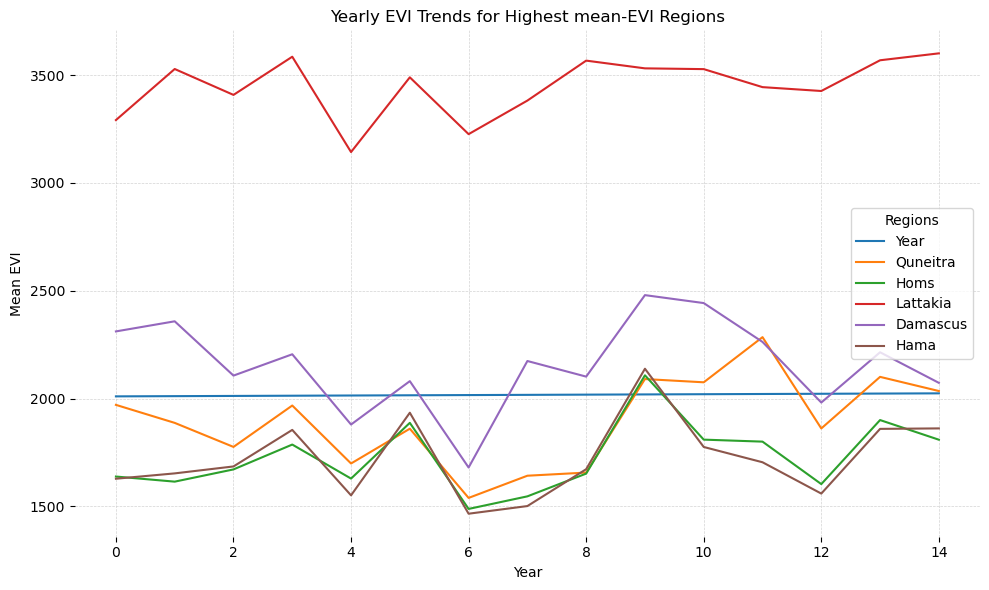

In [36]:
# Plot the line graph for each region
plt.figure(figsize=(10, 6))
for column in highest_admin1_df.columns:  # Loop through columns excluding the index
    plt.plot(highest_admin1_df.index, highest_admin1_df[column], label=column)

# Customize the plot
plt.title("Yearly EVI Trends for Highest mean-EVI Regions")
plt.xlabel("Year")
plt.ylabel("Mean EVI")
plt.legend(title="Regions", loc = "center right")
# Remove all spines (plot boundaries)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.grid(visible=True, which='both', color='lightgray', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [38]:
top_conflict_admin1_list[0] = 'Deir-ez-Zor'
top_conflict_admin1_list[4] = 'Ar-Raqqa'
top_conflict_admin1_list

['Deir-ez-Zor', 'Aleppo', 'Idleb', 'Rural Damascus', 'Ar-Raqqa']

In [39]:
highest_conflict_evi_admin1_df = evi_df_wide[top_conflict_admin1_list]
highest_conflict_evi_admin1_df

ADM1,Deir-ez-Zor,Aleppo,Idleb,Rural Damascus,Ar-Raqqa
Year,,,,,
2010,1664.520124,1612.984051,1802.687507,1798.176497,1419.307132
2011,1473.565862,1452.356619,1854.507261,1782.275825,1232.982974
2012,1422.985623,1577.366043,1753.634993,1613.053025,1351.446141
2013,1368.699354,1695.966816,1844.803749,1805.850419,1461.882014
2014,1353.304398,1340.924496,1427.596530,1434.600140,1264.049566
2015,1415.916118,1762.493088,1877.329513,1627.586778,1457.873684
2016,1260.108831,1218.914263,1343.505485,1341.944081,1149.332943
2017,1291.941143,1229.762596,1545.861296,1606.643854,1091.897987
2018,1298.143633,1353.436699,1721.774168,1409.355620,1272.711384


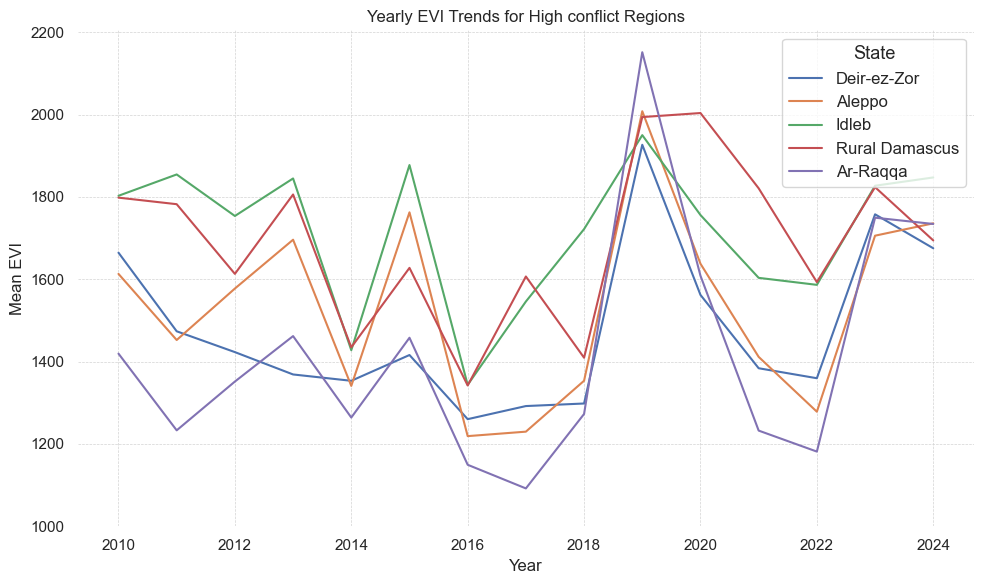

In [40]:
import seaborn as sns

# Set a seaborn style
sns.set_theme(style="whitegrid")

if "Year" in highest_conflict_evi_admin1_df.columns:
    highest_conflict_evi_admin1_df.set_index("Year", inplace=True)

# Plot the line graph for each region
plt.figure(figsize=(10, 6))
for column in highest_conflict_evi_admin1_df.columns:  # Loop through columns excluding the index
    plt.plot(highest_conflict_evi_admin1_df.index, highest_conflict_evi_admin1_df[column],label=column)

# Customize the plot
plt.title("Yearly EVI Trends for High conflict Regions")
plt.xlabel("Year")
plt.ylim(1000,None)
plt.ylabel("Mean EVI")

# Customize legend
plt.legend(title="State", loc="upper right", fontsize=12, title_fontsize=13)
# Add gridlines
plt.grid(visible=True, which='both', color='lightgray',linestyle='--', linewidth=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.tight_layout()

# Show the plot
plt.show()

In [41]:
low_conflict_admin1_list = low_conflict_admin1['State_En'].tolist()
top_conflict_admin1_list = top_conflict_admin1['State_En'].tolist()

In [42]:
low_conflict_admin1_list = low_conflict_admin1_list[1:]
low_conflict_admin1_list[1] = 'As-Sweida'
low_conflict_admin1_list

['Quneitra', 'As-Sweida', 'Lattakia', 'Damascus']

In [43]:
lowest_conflict_evi_admin1_df = evi_df_wide[low_conflict_admin1_list]
lowest_conflict_evi_admin1_df

ADM1,Quneitra,As-Sweida,Lattakia,Damascus
Year,,,,
2010,1970.528443,1165.271437,3291.287667,2311.203426
2011,1887.055002,983.453139,3528.118826,2358.088210
2012,1775.581394,921.240218,3408.047765,2106.307344
2013,1967.522018,984.929232,3585.082975,2205.223252
2014,1698.698063,849.860471,3143.011338,1879.403172
2015,1860.061902,1175.520876,3489.565908,2080.578863
2016,1539.097830,939.283470,3226.058873,1680.099613
2017,1642.000987,1028.134356,3381.718067,2173.963497
2018,1656.562255,924.039858,3567.002089,2101.572554


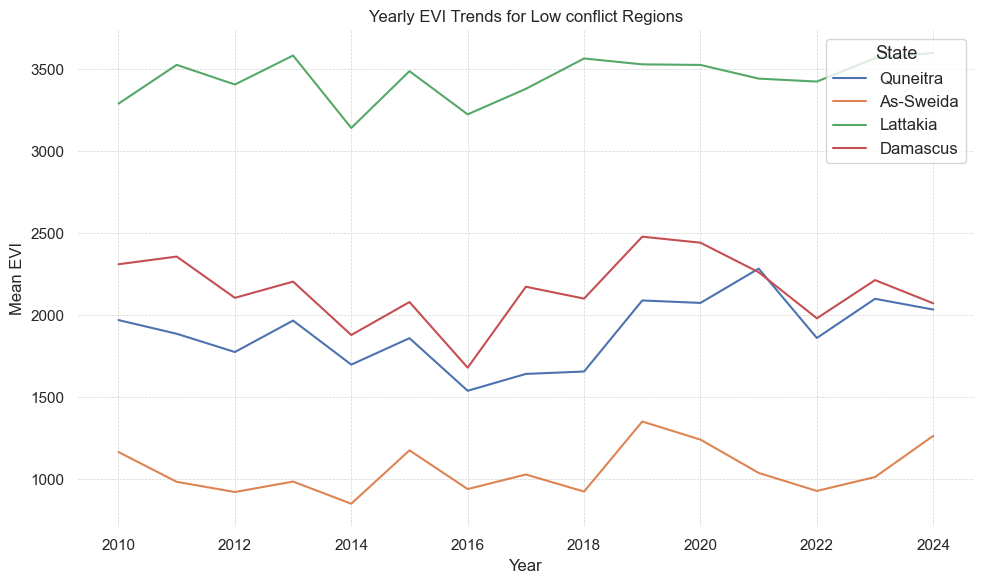

In [44]:
import seaborn as sns

# Set a seaborn style
sns.set_theme(style="whitegrid")


if "Year" in lowest_conflict_evi_admin1_df.columns:
    lowest_conflict_evi_admin1_df.set_index("Year", inplace=True)

# Plot the line graph for each region
plt.figure(figsize=(10, 6))
for column in lowest_conflict_evi_admin1_df.columns:  # Loop through columns excluding the index
    plt.plot(lowest_conflict_evi_admin1_df.index, lowest_conflict_evi_admin1_df[column], label=column)

# Customize the plot
plt.title("Yearly EVI Trends for Low conflict Regions")
plt.xlabel("Year")
plt.ylabel("Mean EVI")
# Customize legend
plt.legend(title="State", loc="upper right", fontsize=12, title_fontsize=13)
# Add gridlines
plt.grid(visible=True, which='both', color='lightgray', linestyle='--', linewidth=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.tight_layout()

# Show the plot
plt.show()

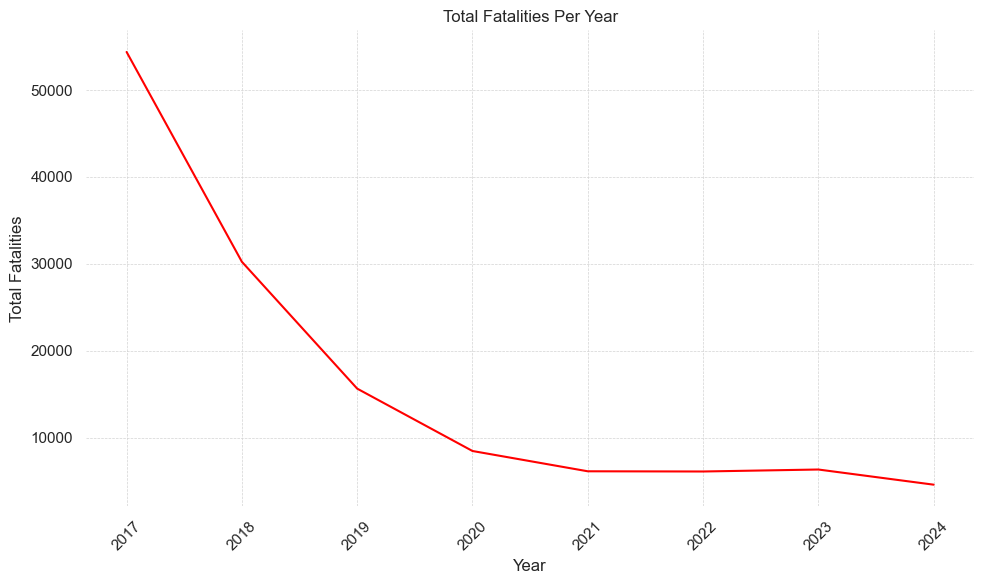

In [45]:
import seaborn as sns

# Set a seaborn style
sns.set_theme(style="whitegrid")

# Aggregate the total fatalities per year
fatalities_per_year = acled_data.groupby('year')['fatalities'].sum().reset_index()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(fatalities_per_year['year'], fatalities_per_year['fatalities'], linestyle='-', color='red')
plt.title('Total Fatalities Per Year')
plt.xlabel('Year')
plt.ylabel('Total Fatalities')

# Add gridlines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.grid(visible=True, which='both', color='lightgray', linestyle='--', linewidth=0.5)

plt.xticks(fatalities_per_year['year'], rotation=45)
plt.tight_layout()

# Show the plot
plt.show()